We will now provide some code for training neural networks in PyTorch.  For simplicity, this code does not run on the GPU.  We begin by sampling the same data used in the kernel regression notebook.

In [1]:
import numpy as np

# Don't forget to set your random seeds so that experiments are all reproducible
SEED = 1717
np.random.seed(SEED)

def sample_data(num_samples):
    X = np.random.uniform(size=(num_samples, 1))
    y = np.sin(10 * X)
    return X, y

n_train, n_test = 30, 1000
X_train, y_train = sample_data(n_train)
X_test, y_test = sample_data(n_test)

# I will be sorting X_test, y_test so that I can easily visualize the test data as a curve
X_test, y_test = zip(*sorted(zip(X_test, y_test), key=lambda x: x[0][0]))
X_test = np.array(X_test)
y_test = np.array(y_test)

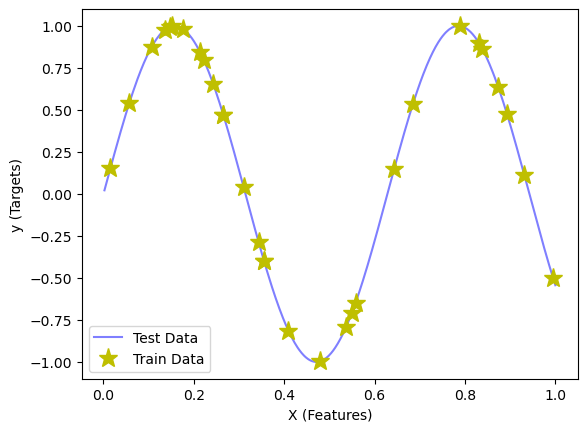

In [2]:
import matplotlib.pyplot as plt

plt.plot(X_test.reshape(-1), y_test.reshape(-1), 'b-', alpha=.5, label='Test Data')
plt.plot(X_train.reshape(-1), y_train.reshape(-1), 'y*', markersize=14, label='Train Data')
plt.xlabel('X (Features)')
plt.ylabel('y (Targets)')
plt.legend()
plt.show()

We need to now convert our data to PyTorch tensors and put them in the right format before we can use PyTorch data loaders. 

In [3]:
import torch
from torch.utils.data import DataLoader

X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)

trainset = list(zip(X_train, y_train))
testset = list(zip(X_test, y_test))

Below, we set up our dataloaders.  The main parameters to be aware of are setting the batch size (how many samples in will our data loader return for us when we iterate) and whether we want to shuffle the data or not.  There is no point to shuffling the data during test time since we are not actually taking any gradients.  

In [34]:
# Set up data loaders for training neural networks
train_loader = DataLoader(trainset, batch_size=128, shuffle=False, num_workers=1)
test_loader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=1)

Next, we need to define our architecture.  We consider a simple 1 hidden layer ReLU network of width 1024.  

In [5]:
import torch.nn as nn
import torch.nn.functional as F

# I typically abstract away nonlinearity so that I can change it easily if needed
class Nonlinearity(nn.Module):
    def __init__(self):
        super(Nonlinearity, self).__init__()

    def forward(self, x):
        return F.relu(x)

# Build a simple 1 hidden layer FC net.  
class Net(nn.Module):

    def __init__(self, input_dim, target_dim):
        super(Net, self).__init__()
        bias = True
        k = 1024
        self.input_dim = input_dim
        self.target_dim = 1
        self.width = k
        self.fc = nn.Sequential(nn.Linear(input_dim, k, bias=bias),
                                Nonlinearity(),
                                nn.Linear(k, target_dim, bias=bias))

    def forward(self, x):
        return self.fc(x)

Lastly, we must define our training and test steps.  For this we need to also select an optimizer.  A standard choice is to use the ```Adam``` optimizer with a learning rate of $10^{-4}$.  During the training and test steps, we must also pick a loss with which to evaluate our model.  Here, we will use the mean squared error (MSELoss).  During the train step, note that we put the model in training mode (```net.train()```) and we zero out gradients before we using ```loss.backward()``` to recompute them.  During the test step, we put our model in evaluation mode (```net.eval()```) and also use ```torch.no_grad()``` to save some memory from requiring gradients for our model.  

In [6]:
from torch.autograd import Variable
import torch.optim as optim
from tqdm import tqdm 

def train_network(trainloader, testloader, num_epochs=100):

    for idx, batch in enumerate(train_loader):
        inputs, labels = batch
        _, input_dim = inputs.shape
        _, output_dim = labels.shape
        break
    
    net = Net(input_dim, output_dim)
    net.double()
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
    
    train_losses = []
    test_losses = []
    
    for t in tqdm(range(num_epochs)):
        train_loss = train_step(net, optimizer, train_loader)
        test_loss = test_step(net, test_loader)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
    return net, train_losses, test_losses
        
def train_step(net, optimizer, train_loader):
    net.train()
    criterion = torch.nn.MSELoss(reduction='mean')
    train_loss = 0.
    for batch_idx, batch in enumerate(train_loader):    
        optimizer.zero_grad()
        inputs, targets = batch 
        output = net(Variable(inputs))
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.cpu().data.numpy() * len(inputs)
    train_loss = train_loss / len(train_loader.dataset)
    return train_loss

def test_step(net, test_loader):
    net.eval()
    criterion = torch.nn.MSELoss(reduction='mean')
    test_loss = 0.
    for batch_idx, batch in enumerate(test_loader):    
        inputs, targets = batch 
        with torch.no_grad():
            output = net(Variable(inputs))
        loss = criterion(output, targets)
        test_loss += loss.cpu().data.numpy() * len(inputs)
    test_loss = test_loss / len(test_loader.dataset)
    return test_loss

    

Below, we train our network for $5000$ epochs and return the network, train losses and test losses. 

In [22]:
num_epochs = 5000
net, train_losses, test_losses = train_network(train_loader, test_loader, num_epochs=num_epochs)

100%|█████████████████████████████████████████████████████| 5000/5000 [05:38<00:00, 14.78it/s]


We then visualize the training and test losses.  We see that both losses are monotonically decreasing and get near zero.  This is a good sign - since we have more width ($1024$) than training examples ($30$), we would expect training loss approaches near $0$.    

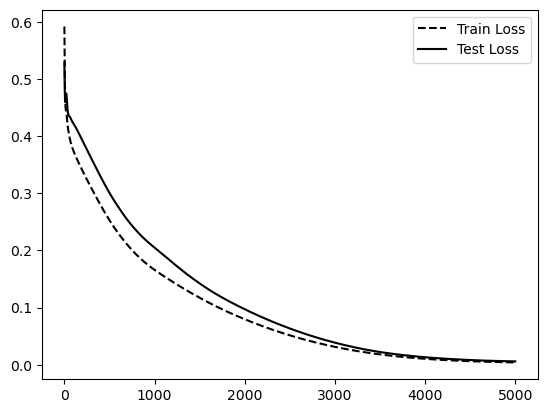

In [23]:
epochs = list(range(num_epochs))
plt.plot(epochs, train_losses, 'k--', label='Train Loss')
plt.plot(epochs, test_losses, 'k-', label='Test Loss')
plt.legend()
plt.show()

In [29]:
def get_preds(net, loader):
    xs = []
    ys = []
    for batch_idx, batch in enumerate(loader):
        inputs, targets = batch
        with torch.no_grad():
            outputs = net(inputs)
            xs.append(inputs)
            ys.append(outputs)
    xs = torch.cat(xs, axis=0)
    ys = torch.cat(ys, axis=0)
    return xs.numpy(), ys.numpy()

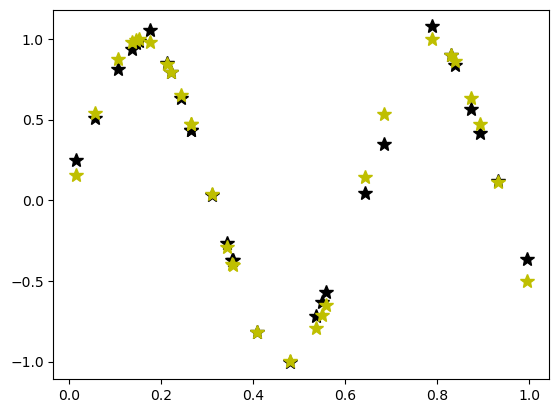

In [38]:
train_x, train_preds = get_preds(net, train_loader)
test_x, test_preds = get_preds(net, test_loader)

plt.plot(train_x, train_preds, 'k*', markersize=10, label='Train Preds')
plt.plot(X_train, y_train, 'y*', markersize=10, label='Train Data')
plt.show()

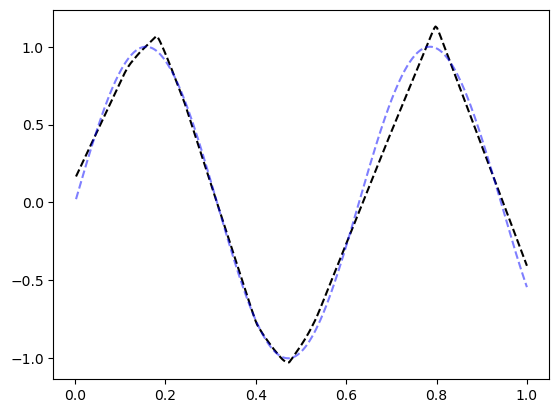

In [39]:
plt.plot(test_x, test_preds, 'k--', label='Test Preds')
plt.plot(X_test, y_test, 'b--', alpha=.5, label='Test Data')
plt.show()

We lastly compare $R^2$ values on training and test samples, and indeed this model achieves great test $R^2$ on this task.  

In [40]:
from sklearn.metrics import r2_score

train_r2 = r2_score(y_train, train_preds)
test_r2 = r2_score(y_test, test_preds)
print("Train R2: ", train_r2, "Test R2: ", test_r2)

Train R2:  0.9902253365482241 Test R2:  0.9866933899131457


There are a lot of follow up items that can be investigated using this notebook.  Below are some examples:

1. What happens if we use a lower width network? 
2. What happens if we increase the depth of the network? 
3. What happens if we use larger learning rate with Adam or we change to SGD? 
4. What happens if we remove the bias terms? 
5. What happens if we change nonlinearity? 
6. What happens if we change the dataset to now have noise in the training data? How do the training and test loss curves look? 
7. What if we use a batch size less than $30$? What if batch size is $1$? How is the rate of convergence affected?